In [20]:
import torch
import torch.nn as nn
from lr_scheduler import OneCycleScheduler
from torch.optim import Optimizer
import matplotlib.pyplot as plt
import math

In [21]:
class CyclicLR(torch.optim.lr_scheduler._LRScheduler):
    """Sets the learning rate of each parameter group according to
    cyclical learning rate policy (CLR). The policy cycles the learning
    rate between two boundaries with a constant frequency, as detailed in
    the paper `Cyclical Learning Rates for Training Neural Networks`_.
    The distance between the two boundaries can be scaled on a per-iteration
    or per-cycle basis.

    Cyclical learning rate policy changes the learning rate after every batch.
    `step` should be called after a batch has been used for training.

    This class has three built-in policies, as put forth in the paper:
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each
        cycle iteration.

    This implementation was adapted from the github repo: `bckenstler/CLR`_

    Args:
        optimizer (Optimizer): Wrapped optimizer.
        base_lr (float or list): Initial learning rate which is the
            lower boundary in the cycle for each parameter group.
        max_lr (float or list): Upper learning rate boundaries in the cycle
            for each parameter group. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore
            max_lr may not actually be reached depending on
            scaling function.
        step_size_up (int): Number of training iterations in the
            increasing half of a cycle. Default: 2000
        step_size_down (int): Number of training iterations in the
            decreasing half of a cycle. If step_size_down is None,
            it is set to step_size_up. Default: None
        mode (str): One of {triangular, triangular2, exp_range}.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
            Default: 'triangular'
        gamma (float): Constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
            Default: 1.0
        scale_fn (function): Custom scaling policy defined by a single
            argument lambda function, where
            0 <= scale_fn(x) <= 1 for all x >= 0.
            If specified, then 'mode' is ignored.
            Default: None
        scale_mode (str): {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on
            cycle number or cycle iterations (training
            iterations since start of cycle).
            Default: 'cycle'
        cycle_momentum (bool): If ``True``, momentum is cycled inversely
            to learning rate between 'base_momentum' and 'max_momentum'.
            Default: True
        base_momentum (float or list): Initial momentum which is the
            lower boundary in the cycle for each parameter group.
            Default: 0.8
        max_momentum (float or list): Upper momentum boundaries in the cycle
            for each parameter group. Functionally,
            it defines the cycle amplitude (max_momentum - base_momentum).
            The momentum at any cycle is the difference of max_momentum
            and some scaling of the amplitude; therefore
            base_momentum may not actually be reached depending on
            scaling function. Default: 0.9
        last_epoch (int): The index of the last batch. This parameter is used when
            resuming a training job. Since `step()` should be invoked after each
            batch instead of after each epoch, this number represents the total
            number of *batches* computed, not the total number of epochs computed.
            When last_epoch=-1, the schedule is started from the beginning.
            Default: -1

    Example:
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        >>> scheduler = torch.optim.CyclicLR(optimizer)
        >>> data_loader = torch.utils.data.DataLoader(...)
        >>> for epoch in range(10):
        >>>     for batch in data_loader:
        >>>         train_batch(...)
        >>>         scheduler.step()


    .. _Cyclical Learning Rates for Training Neural Networks: https://arxiv.org/abs/1506.01186
    .. _bckenstler/CLR: https://github.com/bckenstler/CLR
    """

    def __init__(self,
                 optimizer,
                 base_lr,
                 max_lr,
                 step_size_up=2000,
                 step_size_down=None,
                 mode='triangular',
                 gamma=1.,
                 scale_fn=None,
                 scale_mode='cycle',
                 cycle_momentum=True,
                 base_momentum=0.8,
                 max_momentum=0.9,
                 last_epoch=-1):

        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        self.optimizer = optimizer

        base_lrs = self._format_param('base_lr', optimizer, base_lr)
        if last_epoch == -1:
            for lr, group in zip(base_lrs, optimizer.param_groups):
                group['lr'] = lr

        self.max_lrs = self._format_param('max_lr', optimizer, max_lr)

        step_size_up = float(step_size_up)
        step_size_down = float(step_size_down) if step_size_down is not None else step_size_up
        self.total_size = step_size_up + step_size_down
        self.step_ratio = step_size_up / self.total_size

        if mode not in ['triangular', 'triangular2', 'exp_range'] \
                and scale_fn is None:
            raise ValueError('mode is invalid and scale_fn is None')

        self.mode = mode
        self.gamma = gamma

        if scale_fn is None:
            if self.mode == 'triangular':
                self.scale_fn = self._triangular_scale_fn
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = self._triangular2_scale_fn
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = self._exp_range_scale_fn
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode

        self.cycle_momentum = cycle_momentum
        if cycle_momentum:
            if 'momentum' not in optimizer.defaults:
                raise ValueError('optimizer must support momentum with `cycle_momentum` option enabled')

            base_momentums = self._format_param('base_momentum', optimizer, base_momentum)
            if last_epoch == -1:
                for momentum, group in zip(base_momentums, optimizer.param_groups):
                    group['momentum'] = momentum
        self.base_momentums = list(map(lambda group: group['momentum'], optimizer.param_groups))
        self.max_momentums = self._format_param('max_momentum', optimizer, max_momentum)

        super(CyclicLR, self).__init__(optimizer, last_epoch)

    def _format_param(self, name, optimizer, param):
        """Return correctly formatted lr/momentum for each param group."""
        if isinstance(param, (list, tuple)):
            if len(param) != len(optimizer.param_groups):
                raise ValueError("expected {} values for {}, got {}".format(
                    len(optimizer.param_groups), name, len(param)))
            return param
        else:
            return [param] * len(optimizer.param_groups)

    def _triangular_scale_fn(self, x):
        return 1.

    def _triangular2_scale_fn(self, x):
        return 1 / (2. ** (x - 1))

    def _exp_range_scale_fn(self, x):
        return self.gamma**(x)

    def get_lr(self):
        """Calculates the learning rate at batch index. This function treats
        `self.last_epoch` as the last batch index.

        If `self.cycle_momentum` is ``True``, this function has a side effect of
        updating the optimizer's momentum.
        """
        cycle = math.floor(1 + self.last_epoch / self.total_size)
        x = 1. + self.last_epoch / self.total_size - cycle
        if x <= self.step_ratio:
            scale_factor = x / self.step_ratio
        else:
            scale_factor = (x - 1) / (self.step_ratio - 1)

        lrs = []
        for base_lr, max_lr in zip(self.base_lrs, self.max_lrs):
            base_height = (max_lr - base_lr) * scale_factor
            if self.scale_mode == 'cycle':
                lr = base_lr + base_height * self.scale_fn(cycle)
            else:
                lr = base_lr + base_height * self.scale_fn(self.last_epoch)
            lrs.append(lr)

        if self.cycle_momentum:
            momentums = []
            for base_momentum, max_momentum in zip(self.base_momentums, self.max_momentums):
                base_height = (max_momentum - base_momentum) * scale_factor
                if self.scale_mode == 'cycle':
                    momentum = max_momentum - base_height * self.scale_fn(cycle)
                else:
                    momentum = max_momentum - base_height * self.scale_fn(self.last_epoch)
                momentums.append(momentum)
            for param_group, momentum in zip(self.optimizer.param_groups, momentums):
                param_group['momentum'] = momentum

        return lrs

In [28]:
model = nn.Linear(4, 4)
optimizer = torch.optim.SGD(model.parameters(), 1e-3, momentum=0.9)
LR = 1e-3

[4e-05] [4.137142857142842e-05]


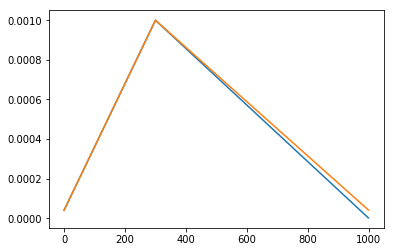

In [42]:
scheduler = OneCycleScheduler(
    optimizer,
    lr=(LR / 25, LR),
    beta=(0.95, 0.85),
    max_steps=1000,
    annealing='linear')

lrs = []
for _ in range(1000):
    scheduler.step()
    lr = scheduler.get_lr()
    
    lrs.append(lr)    
plt.plot(lrs)

scheduler = CyclicLR(
    optimizer, 
    LR / 25, 
    LR, 
    step_size_up=300, 
    step_size_down=700, 
    mode='triangular', 
    gamma=1.)

lrs = []
for _ in range(1000):
    scheduler.step()
    lr = scheduler.get_lr()
    
    lrs.append(lr)    
plt.plot(lrs)
print(lrs[0], lrs[-1])